In [9]:
%load_ext autoreload
%autoreload 2

# Add the path to the parent directory to sys
import sys, os

# If current directory is called 'notebooks', chdir to the parent
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    
sys.path.append('attribution')

from torch.utils.data import DataLoader

import pandas as pd
from constants import ModelNames, DatasetNames, LANGUAGE_MAPPING
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Performance in English with and without COT and constrained decoding

C:\Users\User\AppData\Local\Temp\ipykernel_23100\1854961514.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Condition', y='Accuracy', data=df_eng, palette='viridis')


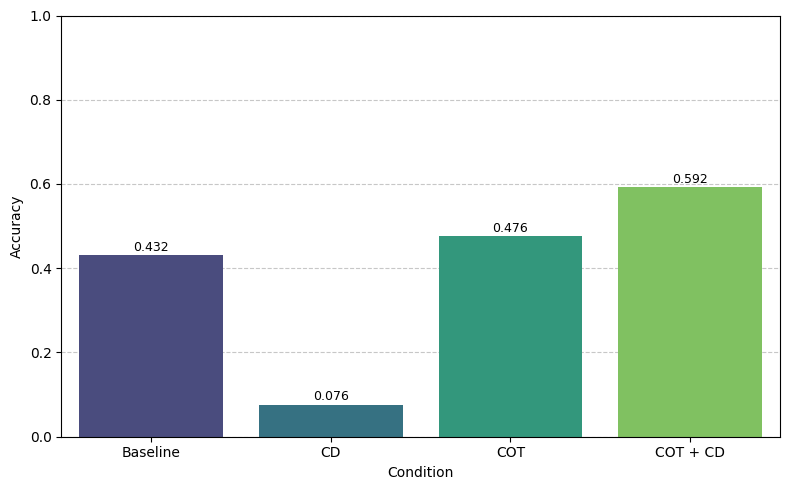

Plot 1 saved as 'results/plots/eng_baseline.png'


In [21]:
# Data dictionary
data = json.load(open('results/metrics/generations.json', 'r'))

# Define output filenames
save_dir = 'results/plots/'
plot1_filename = save_dir + 'eng_baseline.png'

# Ensure plots don't interfere
plt.close('all')

# -----------------------------
# Plot 1: English COT Constrained vs Unconstrained
# -----------------------------
# More convenient structure where conditions are keys to accuracy values
accuracy_values = {
    'Baseline': data["mgsm_en_regular_unconstrained_Qwen2.5-1.5B-Instruct"],
    'CD': data["mgsm_en_regular_constrained_Qwen2.5-1.5B-Instruct"],
    'COT': data["mgsm_en_COT_unconstrained_Qwen2.5-1.5B-Instruct"],
    'COT + CD': data["mgsm_en_COT_constrained_Qwen2.5-1.5B-Instruct"],
}

# Convert to DataFrame format required by seaborn
df_eng = pd.DataFrame({
    'Condition': list(accuracy_values.keys()),
    'Accuracy': list(accuracy_values.values())
})

plt.figure(figsize=(8, 5))  # Slightly larger figure for better readability

# Create the bar plot
ax = sns.barplot(x='Condition', y='Accuracy', data=df_eng, palette='viridis')

# Add a grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(df_eng['Accuracy']):
    ax.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=9)

# Customize the plot
# plt.title('Accuracy on English subset with Chain-of-Thought (COT) and Constrained Decoding (CD)')
plt.ylim(0, 1)
plt.ylabel('Accuracy')

# Ensure grid is behind bars
ax.set_axisbelow(True)

# Save and show the plot
plt.tight_layout()  # Adjust spacing
plt.savefig(plot1_filename, dpi=300)  # Higher DPI for better quality
plt.show()
print(f"Plot 1 saved as '{plot1_filename}'")

## Performance across languages with and without COT using constrained decoding

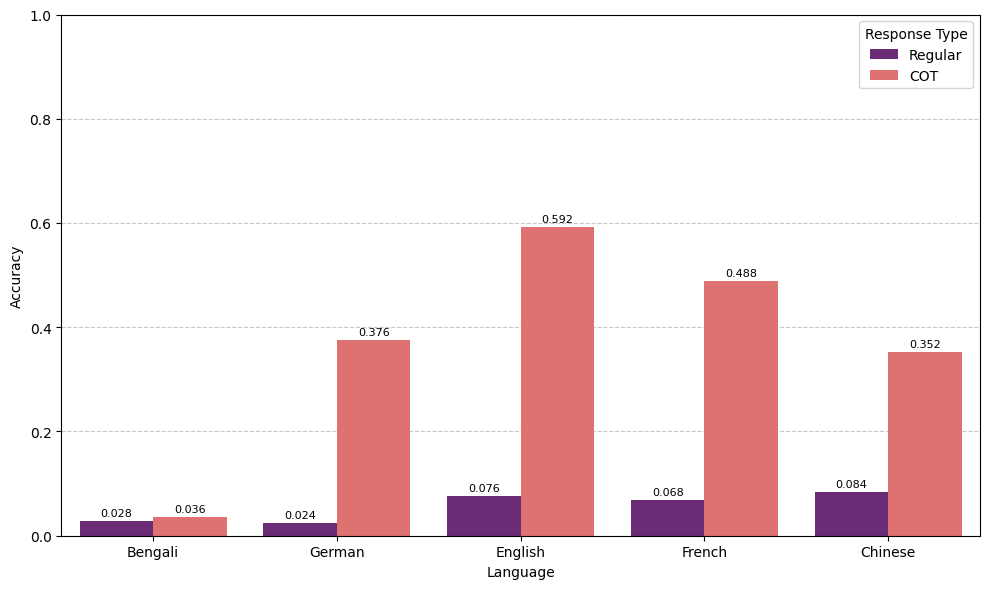

Plot 2 saved as 'results/plots/multi-lang_performance.png'


In [32]:
# -----------------------------
# Plot 2: Accuracy by Language for Constrained Responses (COT vs Regular)
# -----------------------------
languages = ['bn', 'de', 'en', 'fr', 'zh']
plot2_filename = save_dir + 'multi-lang_performance.png'
plot_data = []

for lang in languages:
    reg_key = f"mgsm_{lang}_regular_constrained_Qwen2.5-1.5B-Instruct"
    cot_key = f"mgsm_{lang}_COT_constrained_Qwen2.5-1.5B-Instruct"
    
    # Use full language name from LANGUAGE_MAPPING
    lang_name = LANGUAGE_MAPPING[lang]
    
    # Only add data points if the keys exist
    
    plot_data.append({'Language': lang_name, 'Type': 'Regular', 'Accuracy': data[reg_key]})
    plot_data.append({'Language': lang_name, 'Type': 'COT', 'Accuracy': data[cot_key]})

df_plot2 = pd.DataFrame(plot_data)

plt.figure(figsize=(10, 6))  # Slightly wider to accommodate language names

# Create the bar plot
ax = sns.barplot(x='Language', y='Accuracy', hue='Type', data=df_plot2, palette='magma')

# Add a grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar, but only for non-zero values
for i, p in enumerate(ax.patches):
    height = p.get_height()
    if height > 0.001:  # Only label bars with non-zero values
        ax.text(p.get_x() + p.get_width()/2., height + 0.01,
                f'{height:.3f}', ha="center", fontsize=8)

# Customize the plot
# plt.title('Accuracy by Language for Constrained Responses')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.legend(title='Response Type')

# Ensure grid is behind bars
ax.set_axisbelow(True)

# Save and show the plot
plt.tight_layout()  # Adjust spacing
plt.savefig(plot2_filename, dpi=300)  # Higher DPI for better quality
plt.show()
print(f"Plot 2 saved as '{plot2_filename}'")

## Number of tokens across generations

C:\Users\User\AppData\Local\Temp\ipykernel_23100\2917632269.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Language', x='Average Token Count', data=token_df, palette='viridis')


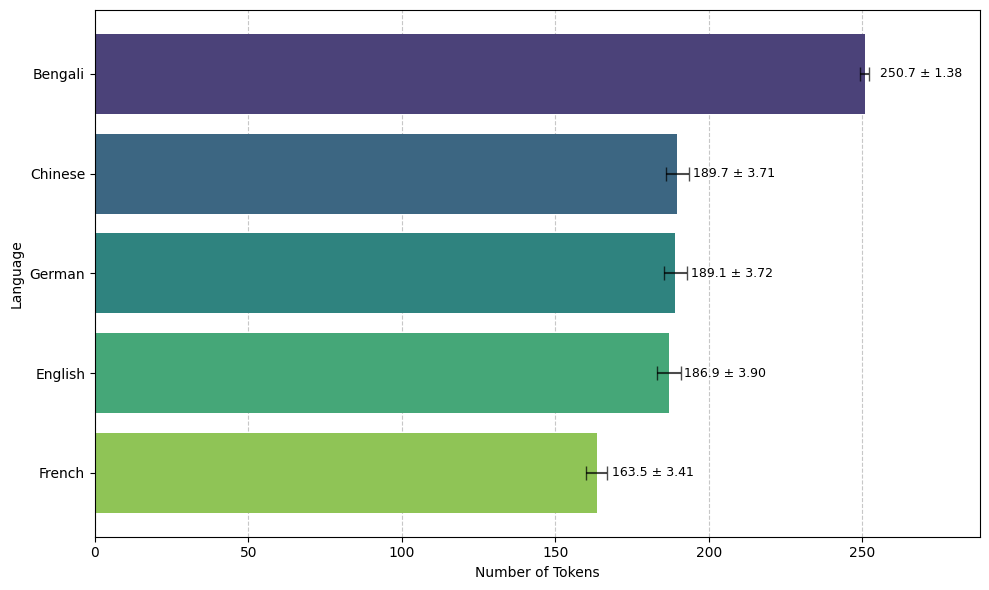

In [33]:
from transformers import AutoTokenizer
import numpy as np

# Load the tokenizer, should be the same for all qwen models
tokenizer = AutoTokenizer.from_pretrained(ModelNames.QwenInstruct)

# Initialize list to collect token counts
token_data = []

# Calculate token counts for each language
for lang in ['en', 'bn', 'de', 'fr', 'zh']:
    file_path = f"results/generations/mgsm_{lang}_COT_constrained_Qwen2.5-1.5B-Instruct_results.csv"
    
    if not os.path.exists(file_path):
        print(f"Warning: File not found: {file_path}")
        continue
    
    # Load generations
    df = pd.read_csv(file_path)
    
    # Calculate token counts for each response
    token_counts = [len(tokenizer.encode(response)) for response in df['response']]
    
    # Calculate statistics
    avg_tokens = np.mean(token_counts)
    std_tokens = np.std(token_counts)
    # Calculate standard error (standard deviation / sqrt(sample size))
    std_error = std_tokens / np.sqrt(len(token_counts))
    
    # Add to data collection
    token_data.append({
        'Language': LANGUAGE_MAPPING[lang],
        'Average Token Count': avg_tokens,
        'Std Error': std_error,
        'Sample Size': len(token_counts)
    })

# Convert to DataFrame and sort by Average Token Count (descending)
token_df = pd.DataFrame(token_data)
token_df = token_df.sort_values('Average Token Count', ascending=False).reset_index(drop=True)

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(y='Language', x='Average Token Count', data=token_df, palette='viridis')

# Add grid
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add error bars showing standard error
for i, row in token_df.iterrows():
    plt.errorbar(row['Average Token Count'], i, xerr=row['Std Error'], 
                 fmt='none', color='black', capsize=5, alpha=0.7)

# Add value labels placed at end of bars to avoid overlap
for i, row in token_df.iterrows():
    # Place label at the end of the bar
    ax.text(row['Average Token Count'] + 5, i, 
            f"{row['Average Token Count']:.1f} ± {row['Std Error']:.2f}", 
            va='center', ha='left', fontsize=9, color='black')

# Customize plot
# plt.title('Average Token Count by Language (COT Responses)')
plt.xlabel('Number of Tokens')
plt.xlim(0, token_df['Average Token Count'].max() * 1.15)  # Add extra space for labels
plt.tight_layout()

# Ensure grid is behind bars
ax.set_axisbelow(True)

# Save and show
plt.savefig('results/plots/token_counts_by_language.png', dpi=300)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_23100\243095780.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Language', x='Average Step Count', data=step_df, palette='magma')


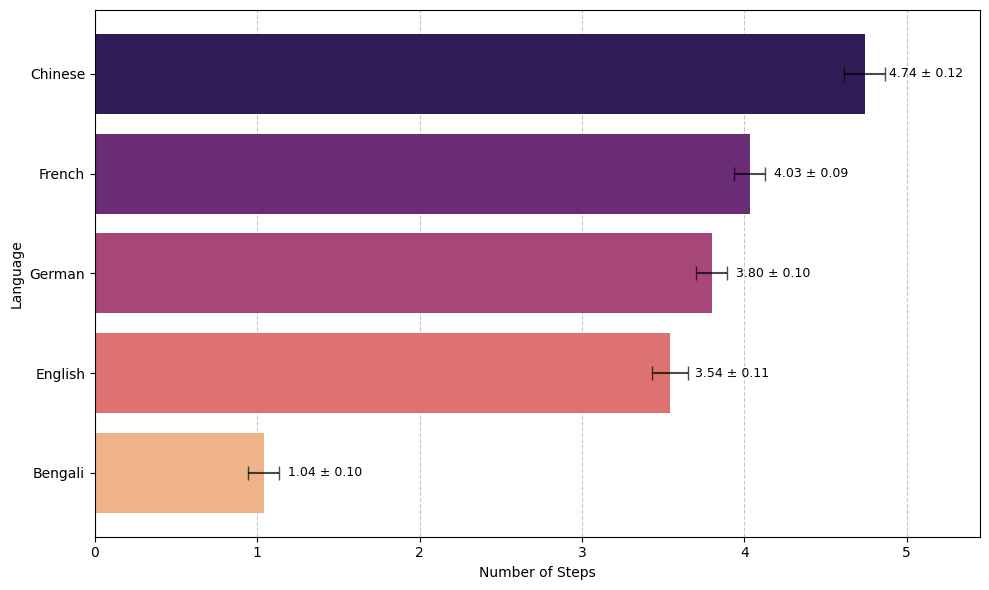

In [36]:
# Initialize list to collect reasoning step counts
step_data = []

# Calculate reasoning steps for each language
for lang in ['en', 'bn', 'de', 'fr', 'zh']:
    file_path = f"results/generations/mgsm_{lang}_COT_constrained_Qwen2.5-1.5B-Instruct_results.csv"
    
    if not os.path.exists(file_path):
        print(f"Warning: File not found: {file_path}")
        continue
    
    # Load generations
    df = pd.read_csv(file_path)
    
    # Calculate reasoning steps for each response (newlines - 2)
    step_counts = [response.count('\n') - 2 for response in df['response']]
    
    # Calculate statistics
    avg_steps = np.mean(step_counts)
    std_steps = np.std(step_counts)
    # Calculate standard error (standard deviation / sqrt(sample size))
    std_error = std_steps / np.sqrt(len(step_counts))
    
    # Add to data collection
    step_data.append({
        'Language': LANGUAGE_MAPPING[lang],
        'Average Step Count': avg_steps,
        'Std Error': std_error,
        'Sample Size': len(step_counts)
    })

# Convert to DataFrame and sort by Average Step Count (descending)
step_df = pd.DataFrame(step_data)
step_df = step_df.sort_values('Average Step Count', ascending=False).reset_index(drop=True)

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(y='Language', x='Average Step Count', data=step_df, palette='magma')

# Add grid
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add error bars showing standard error
for i, row in step_df.iterrows():
    plt.errorbar(row['Average Step Count'], i, xerr=row['Std Error'], 
                 fmt='none', color='black', capsize=5, alpha=0.7)

# Add value labels placed at end of bars
for i, row in step_df.iterrows():
    # Place label at the end of the bar
    ax.text(row['Average Step Count'] + 0.15, i, 
            f"{row['Average Step Count']:.2f} ± {row['Std Error']:.2f}", 
            va='center', ha='left', fontsize=9, color='black')

# Customize plot
# plt.title('Average Number of Reasoning Steps by Language (COT Responses)')
plt.xlabel('Number of Steps')
plt.xlim(0, step_df['Average Step Count'].max() * 1.15)  # Add extra space for labels
plt.tight_layout()

# Ensure grid is behind bars
ax.set_axisbelow(True)

# Save and show
plt.savefig('results/plots/reasoning_steps_by_language.png', dpi=300)
plt.show()

## Analyzing importance of Steps


Invalid response counts:
English: 0
Bengali: 33
German: 0
French: 0
Chinese: 0


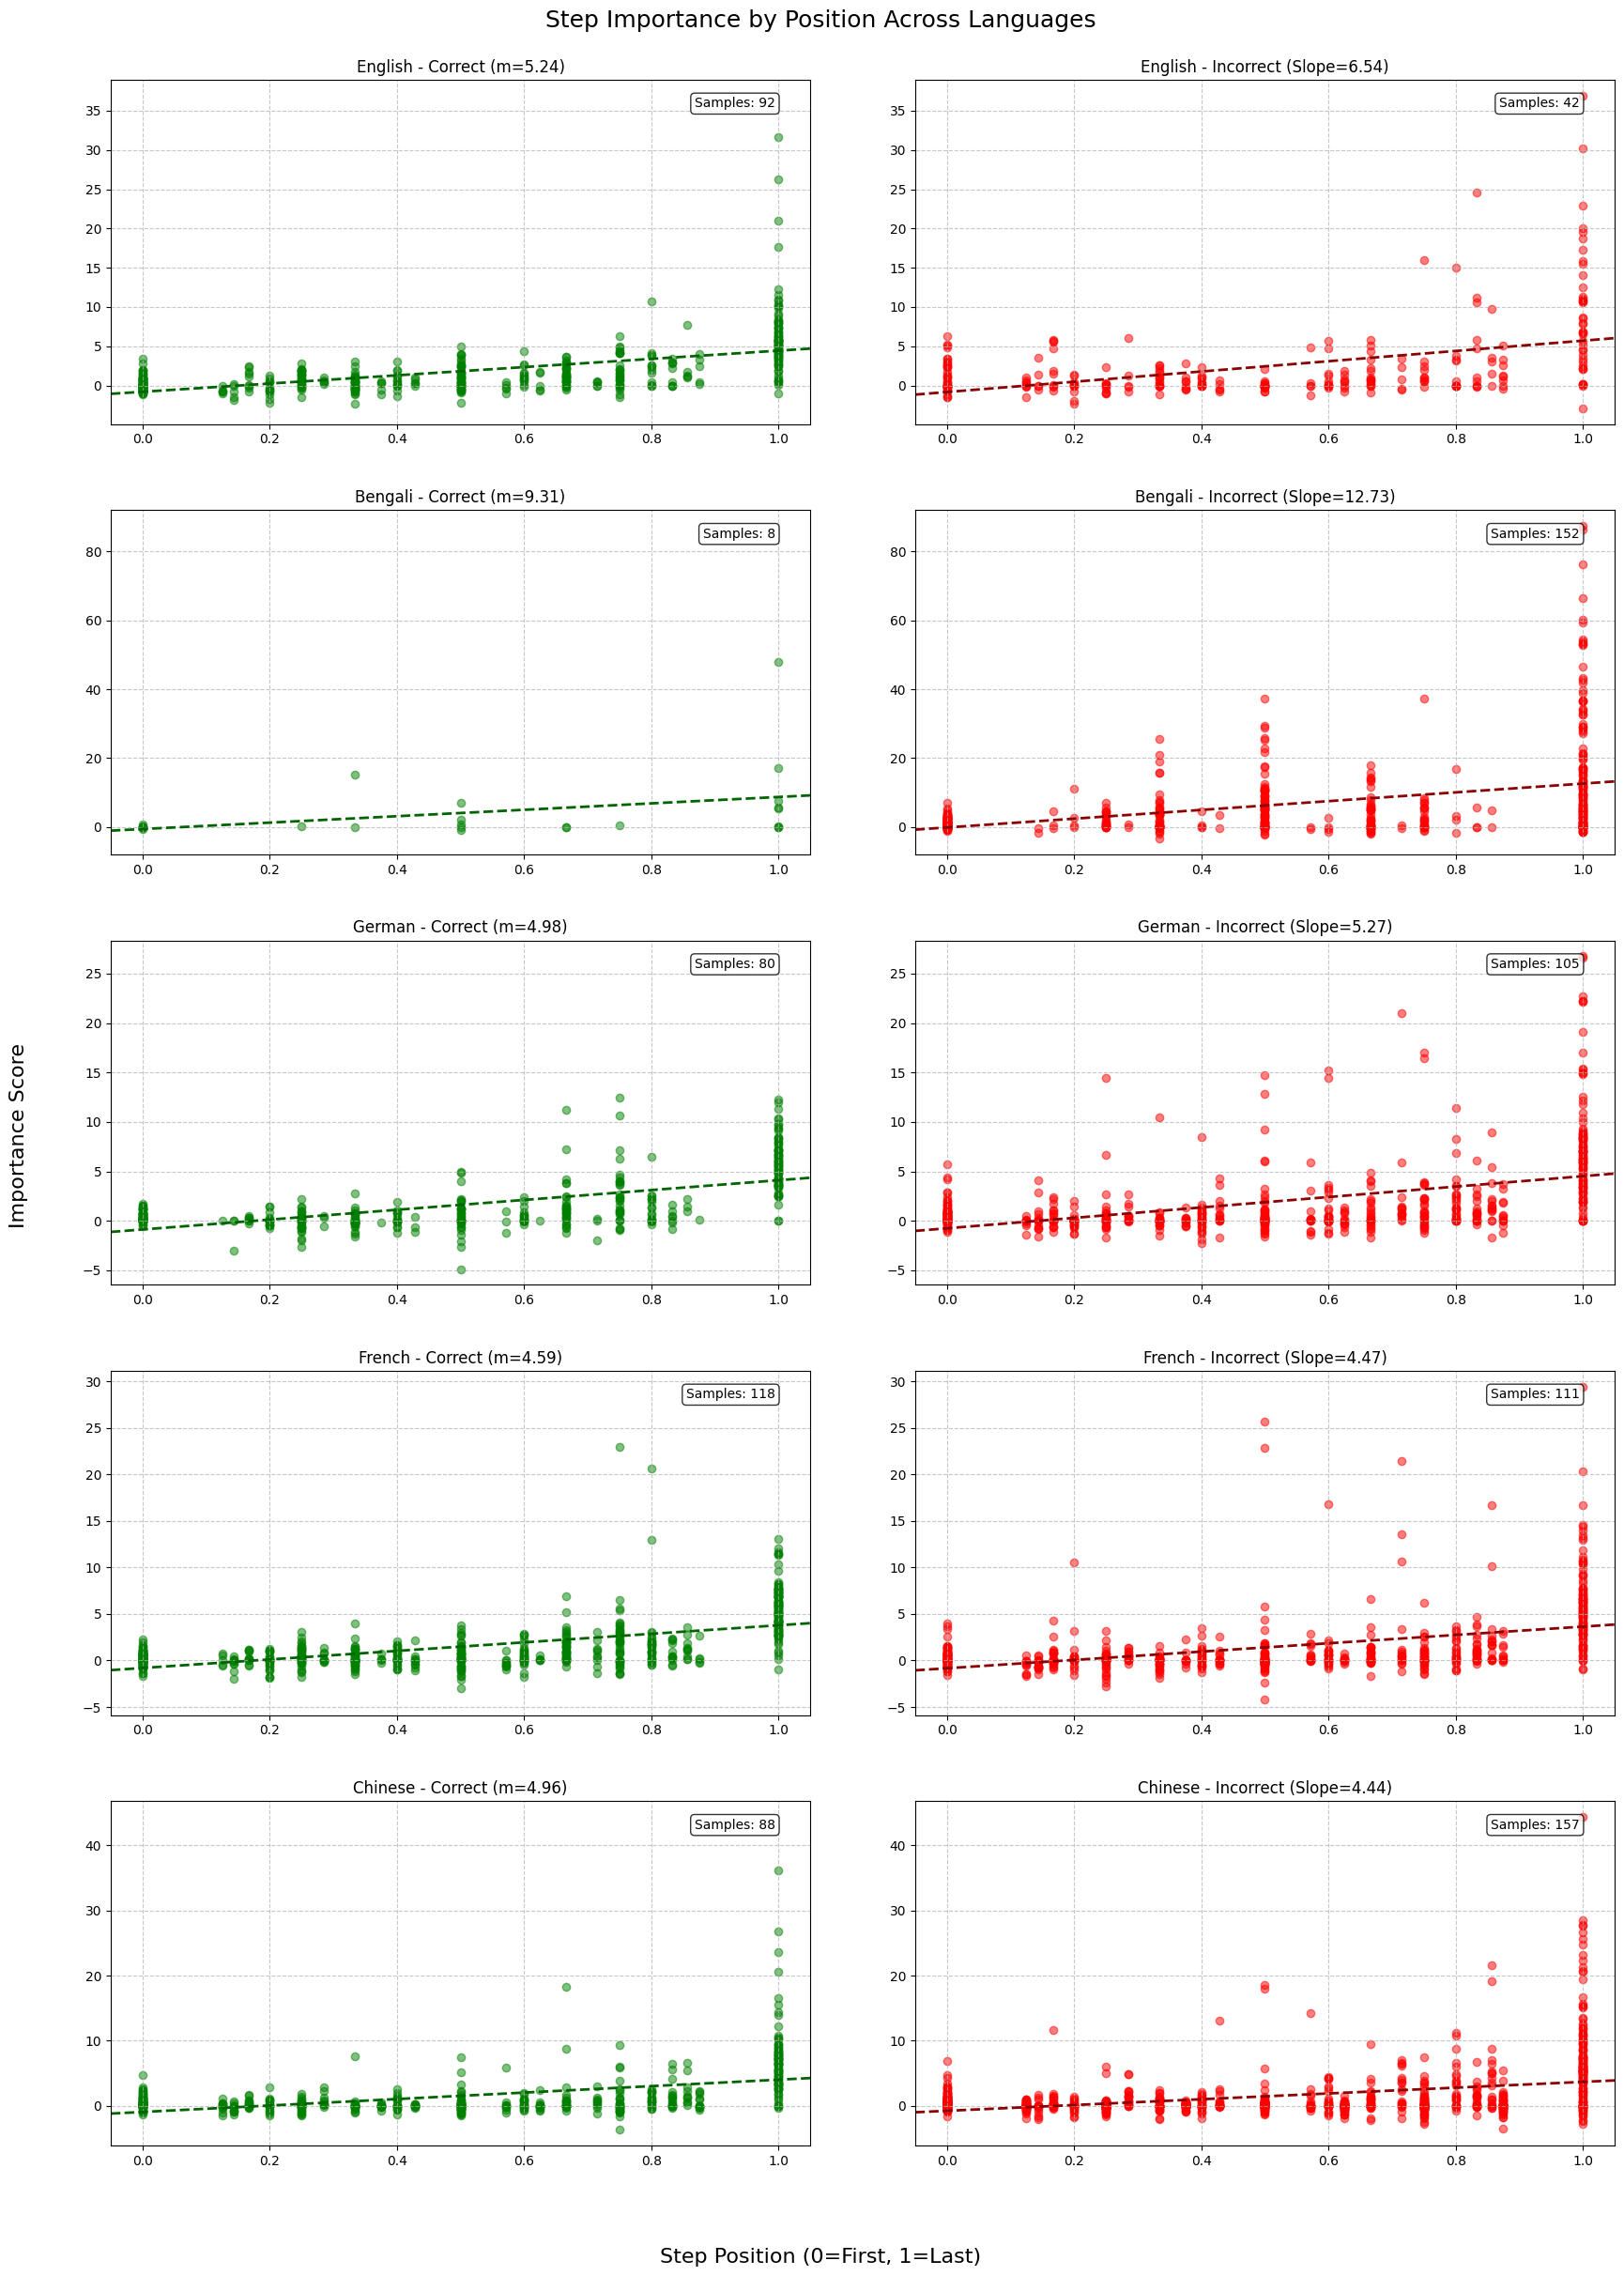

In [46]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from attribution.constants import LANGUAGE_MAPPING

# List of languages
languages = ['en', 'bn', 'de', 'fr', 'zh']

# Set up a figure with subplots for each language and correctness
fig = plt.figure(figsize=(18, 25))
gs = GridSpec(5, 2, figure=fig, hspace=0.25, wspace=0.15)  # Reduced spacing between plots

# Track invalid responses
invalid_counts = {}

# Process each language
for i, lang in enumerate(languages):
    # Define file path
    file_path = f'results/contextcite/contextcite_{lang}_Qwen2.5-1.5B-Instruct_COT.json'
    
    try:
        # Load data
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Initialize lists to store processed data
        x_correct = []  # Proportion values for correct answers
        y_correct = []  # Importance values for correct answers
        x_incorrect = []  # Proportion values for incorrect answers
        y_incorrect = []  # Importance values for incorrect answers
        invalid_count = 0
        all_importance_values = []  # For calculating consistent y limits
        
        # Track correct and incorrect sample counts properly
        correct_sample_count = 0
        incorrect_sample_count = 0
        
        # Process each sample
        for sample in data:
            # Skip invalid model answers
            model_answer = sample.get('model_gen_answer')
            if model_answer == '[invalid]' or model_answer is None:
                invalid_count += 1
                continue
            
            # Try to convert to float for comparison
            try:
                model_answer_float = float(model_answer)
                actual_answer_float = float(sample['actual_answer'])
                is_correct = abs(model_answer_float - actual_answer_float) < 1e-6
            except (ValueError, TypeError):
                # If conversion fails, compare as is
                is_correct = str(model_answer) == str(sample['actual_answer'])
            
            # Increment the appropriate sample counter
            if is_correct:
                correct_sample_count += 1
            else:
                incorrect_sample_count += 1
            
            # Get all calculation steps (including the header "Step-by-Step Answer:")
            calculation_steps = sample['lines_and_importance']
            
            # Calculate total number of steps
            total_steps = len(calculation_steps)
            
            # Skip entries with no steps
            if total_steps == 0:
                continue
                
            # Process each step's importance
            for step_idx, line_data in enumerate(calculation_steps):
                # Calculate proportion to range from 0 (first step) to 1 (last step)
                # If there's only one step, proportion will be 0
                proportion = step_idx / (total_steps - 1) if total_steps > 1 else 0
                importance = line_data['importance']
                
                # Track all importance values for y-limit calculation
                all_importance_values.append(importance)
                
                # Add to appropriate list based on correctness
                if is_correct:
                    x_correct.append(proportion)
                    y_correct.append(importance)
                else:
                    x_incorrect.append(proportion)
                    y_incorrect.append(importance)
        
        # Record invalid count
        invalid_counts[lang] = invalid_count
        
        # Calculate consistent y limits for both plots
        if all_importance_values:
            y_min = min(all_importance_values)
            y_max = max(all_importance_values)
            # Add some padding
            y_range = y_max - y_min
            y_min -= y_range * 0.05
            y_max += y_range * 0.05
        else:
            # Default if no data
            y_min, y_max = -5, 5
        
        # Create subplot for CORRECT answers
        ax_correct = fig.add_subplot(gs[i, 0])
        
        # Plot scatter points for correct answers
        ax_correct.scatter(x_correct, y_correct, alpha=0.5, color='green')
        
        # Linear regression slope for correct answers
        correct_slope = None
        if len(x_correct) > 3:
            # Use a linear fit (degree=1)
            z_correct = np.polyfit(x_correct, y_correct, 1)
            p_correct = np.poly1d(z_correct)
            correct_slope = z_correct[0]  # First coefficient is the slope
            
            # Generate points for the line
            x_line = np.linspace(-0.05, 1.05, 100)
            y_line = p_correct(x_line)
            
            # Plot regression line
            ax_correct.plot(x_line, y_line, color='darkgreen', linestyle='--', linewidth=2)
        
        # REMOVED individual y-axis labels to avoid duplication
        
        # Add the slope to the title if available
        if correct_slope is not None:
            title = f'{LANGUAGE_MAPPING[lang]} - Correct (m={correct_slope:.2f})'
        else:
            title = f'{LANGUAGE_MAPPING[lang]} - Correct'
            
        ax_correct.set_title(title, fontsize=12)
        ax_correct.set_xlim(-0.05, 1.05)  # Extended x limits for better visibility
        ax_correct.set_ylim(y_min, y_max)  # Use consistent y limits
        ax_correct.grid(True, linestyle='--', alpha=0.7)
        
        # Add the correct sample count in the top right corner
        ax_correct.text(0.95, 0.95, f"Samples: {correct_sample_count}", 
                transform=ax_correct.transAxes, ha='right', va='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Create subplot for INCORRECT answers
        ax_incorrect = fig.add_subplot(gs[i, 1])
        
        # Plot scatter points for incorrect answers
        ax_incorrect.scatter(x_incorrect, y_incorrect, alpha=0.5, color='red')
        
        # Linear regression slope for incorrect answers
        incorrect_slope = None
        if len(x_incorrect) > 3:
            # Use a linear fit (degree=1)
            z_incorrect = np.polyfit(x_incorrect, y_incorrect, 1)
            p_incorrect = np.poly1d(z_incorrect)
            incorrect_slope = z_incorrect[0]  # First coefficient is the slope
            
            # Generate points for the line
            x_line = np.linspace(-0.05, 1.05, 100)
            y_line = p_incorrect(x_line)
            
            # Plot regression line
            ax_incorrect.plot(x_line, y_line, color='darkred', linestyle='--', linewidth=2)
        
        # Add the slope to the title if available
        if incorrect_slope is not None:
            title = f'{LANGUAGE_MAPPING[lang]} - Incorrect (Slope={incorrect_slope:.2f})'
        else:
            title = f'{LANGUAGE_MAPPING[lang]} - Incorrect'
            
        ax_incorrect.set_title(title, fontsize=12)
        ax_incorrect.set_xlim(-0.05, 1.05)  # Extended x limits for better visibility
        ax_incorrect.set_ylim(y_min, y_max)  # Use consistent y limits
        ax_incorrect.grid(True, linestyle='--', alpha=0.7)
        
        # Add the incorrect sample count in the top right corner
        ax_incorrect.text(0.95, 0.95, f"Samples: {incorrect_sample_count}", 
                transform=ax_incorrect.transAxes, ha='right', va='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
    except Exception as e:
        print(f"Error processing {lang}: {e}")

# Add a common y-axis label with more space
fig.text(0.02, 0.5, 'Importance Score', va='center', rotation='vertical', fontsize=16)

# Add a common x-axis label (single instance) - properly centered
fig.text(0.5, 0.02, 'Step Position (0=First, 1=Last)', ha='center', fontsize=16)

# REMOVED tight_layout() to avoid conflicts with subplots_adjust()

# Adjust layout with optimized spacing
fig.suptitle('Step Importance by Position Across Languages', fontsize=18)
plt.subplots_adjust(top=0.95, bottom=0.07, left=0.08, right=0.97, hspace=0.3, wspace=0.2)

# Save the figure
plt.savefig('results/plots/step_importance_by_position_separated.png', dpi=300)

# Print invalid counts
print("\nInvalid response counts:")
for lang, count in invalid_counts.items():
    print(f"{LANGUAGE_MAPPING[lang]}: {count}")

plt.show()

## Attempting to predict whether the answer will be correct

In [55]:
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import lightgbm as lgb
from collections import Counter
import matplotlib.pyplot as plt

# List of languages
languages = ['en', 'bn', 'de', 'fr', 'zh']

# Create DataFrames to store results
stats_df = pd.DataFrame(columns=[
    'Setting', 'Total Samples', 'Correct Samples', 'Correct %', 
    'Incorrect Samples', 'Incorrect %', 'Train Size', 'Val Size'
])

performance_df = pd.DataFrame(columns=[
    'Setting', 'Model', 'Train Accuracy', 'Val Accuracy', 'Val Precision', 
    'Val Recall', 'Val F1 Score'
])

# Read and process data
def load_data_from_json(languages_to_use):
    all_importances = []
    all_correctness = []
    max_steps = 0
    
    # First pass to find max_steps
    for lang in languages_to_use:
        file_path = f'results/contextcite/contextcite_{lang}_Qwen2.5-1.5B-Instruct_COT.json'
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                
            for sample in data:
                # Skip invalid model answers
                model_answer = sample.get('model_gen_answer')
                if model_answer == '[invalid]' or not isinstance(model_answer, (int, float, str)):
                    continue
                
                # Get number of steps 
                steps = len(sample['lines_and_importance'])
                if steps > max_steps:
                    max_steps = steps
        except Exception as e:
            print(f"Error reading {lang}: {e}")
    
    # Second pass to create features with proper padding
    for lang in languages_to_use:
        file_path = f'results/contextcite/contextcite_{lang}_Qwen2.5-1.5B-Instruct_COT.json'
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                
            for sample in data:
                # Skip invalid model answers
                model_answer = sample.get('model_gen_answer')
                if model_answer == '[invalid]' or not isinstance(model_answer, (int, float, str)):
                    continue
                
                # Determine if answer is correct
                try:
                    model_answer_float = float(model_answer)
                    actual_answer_float = float(sample['actual_answer'])
                    is_correct = abs(model_answer_float - actual_answer_float) < 1e-6
                except (ValueError, TypeError):
                    # If conversion fails, compare as is
                    is_correct = str(model_answer) == str(sample['actual_answer'])
                
                # Extract importance values
                importances = [step['importance'] for step in sample['lines_and_importance']]
                
                # Pad with zeros
                padded_importances = importances + [0] * (max_steps - len(importances))
                
                all_importances.append(padded_importances)
                all_correctness.append(1 if is_correct else 0)
                
        except Exception as e:
            print(f"Error processing {lang}: {e}")
    
    return np.array(all_importances), np.array(all_correctness), max_steps

# Define a function to train and evaluate models
def train_and_evaluate_models(X, y, setting_name):
    global stats_df, performance_df
    
    # Create stratified train-val split (80-20)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Record dataset statistics
    stats_df = pd.concat([
        stats_df, 
        pd.DataFrame([{
            'Setting': setting_name,
            'Total Samples': len(y),
            'Correct Samples': sum(y),
            'Correct %': f"{sum(y)/len(y)*100:.1f}%",
            'Incorrect Samples': len(y) - sum(y),
            'Incorrect %': f"{(len(y) - sum(y))/len(y)*100:.1f}%",
            'Train Size': len(y_train),
            'Val Size': len(y_val)
        }])
    ], ignore_index=True)
    
    # Train Logistic Regression
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    
    # Train LightGBM
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
    }
    
    gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=100,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
    )
    
    # Logistic Regression Predictions
    lr_train_preds = lr.predict(X_train)
    lr_val_preds = lr.predict(X_val)
    
    # Add Logistic Regression performance to DataFrame
    performance_df = pd.concat([
        performance_df,
        pd.DataFrame([{
            'Setting': setting_name,
            'Model': 'Logistic Regression',
            'Train Accuracy': f"{accuracy_score(y_train, lr_train_preds):.4f}",
            'Val Accuracy': f"{accuracy_score(y_val, lr_val_preds):.4f}",
            'Val Precision': f"{precision_score(y_val, lr_val_preds, zero_division=0):.4f}",
            'Val Recall': f"{recall_score(y_val, lr_val_preds, zero_division=0):.4f}",
            'Val F1 Score': f"{f1_score(y_val, lr_val_preds, zero_division=0):.4f}"
        }])
    ], ignore_index=True)
    
    # LightGBM Predictions
    gbm_train_preds = (gbm.predict(X_train) > 0.5).astype(int)
    gbm_val_preds = (gbm.predict(X_val) > 0.5).astype(int)
    
    # Add LightGBM performance to DataFrame
    performance_df = pd.concat([
        performance_df,
        pd.DataFrame([{
            'Setting': setting_name,
            'Model': 'LightGBM',
            'Train Accuracy': f"{accuracy_score(y_train, gbm_train_preds):.4f}",
            'Val Accuracy': f"{accuracy_score(y_val, gbm_val_preds):.4f}",
            'Val Precision': f"{precision_score(y_val, gbm_val_preds, zero_division=0):.4f}",
            'Val Recall': f"{recall_score(y_val, gbm_val_preds, zero_division=0):.4f}",
            'Val F1 Score': f"{f1_score(y_val, gbm_val_preds, zero_division=0):.4f}"
        }])
    ], ignore_index=True)
    
    # Create feature importance DataFrame for both models
    feature_importance_df = pd.DataFrame({
        'Step': range(X.shape[1]),
        'LogReg_Importance': np.abs(lr.coef_[0]),
        'LightGBM_Importance': gbm.feature_importance()
    })
    
    # Sort by LightGBM importance
    feature_importance_df = feature_importance_df.sort_values(
        by='LightGBM_Importance', ascending=False
    ).reset_index(drop=True)
    
    # Plot top 10 feature importances
    plt.figure(figsize=(12, 6))
    
    # LightGBM subplot
    plt.subplot(1, 2, 1)
    top_features_lgb = feature_importance_df.head(10)
    plt.barh(np.arange(len(top_features_lgb)), top_features_lgb['LightGBM_Importance'])
    plt.yticks(np.arange(len(top_features_lgb)), [f"Step {step}" for step in top_features_lgb['Step']])
    plt.title('LightGBM Feature Importance')
    plt.xlabel('Importance')
    
    # LogReg subplot
    plt.subplot(1, 2, 2)
    top_features_lr = feature_importance_df.sort_values(by='LogReg_Importance', ascending=False).head(10)
    plt.barh(np.arange(len(top_features_lr)), top_features_lr['LogReg_Importance'])
    plt.yticks(np.arange(len(top_features_lr)), [f"Step {step}" for step in top_features_lr['Step']])
    plt.title('Logistic Regression Coefficient Magnitude')
    plt.xlabel('|Coefficient|')
    
    plt.tight_layout()
    plt.savefig(f'results/plots/{setting_name}_feature_importance.png', dpi=300)
    plt.close()
    
    return lr, gbm, feature_importance_df

# English-only analysis
X_en, y_en, max_steps_en = load_data_from_json(['en'])
en_lr, en_gbm, en_importance_df = train_and_evaluate_models(X_en, y_en, "English-only")

# Multilingual analysis
X_multi, y_multi, max_steps_multi = load_data_from_json(languages)
multi_lr, multi_gbm, multi_importance_df = train_and_evaluate_models(X_multi, y_multi, "Multilingual")

# Save DataFrames to CSV
stats_df.to_csv('results/analysis/dataset_statistics.csv', index=False)
performance_df.to_csv('results/analysis/model_performance.csv', index=False)
en_importance_df.to_csv('results/analysis/english_feature_importance.csv', index=False)
multi_importance_df.to_csv('results/analysis/multilingual_feature_importance.csv', index=False)

In [56]:
# Display final DataFrames
print("\n=== DATASET STATISTICS ===")
display(stats_df)


=== DATASET STATISTICS ===


,Setting,Total Samples,Correct Samples,Correct %,Incorrect Samples,Incorrect %,Train Size,Val Size
0,English-only,134,92,68.7%,42,31.3%,107,27
1,Multilingual,953,386,40.5%,567,59.5%,762,191


In [57]:
print("\n=== MODEL PERFORMANCE ===")
display(performance_df)


=== MODEL PERFORMANCE ===


,Setting,Model,Train Accuracy,Val Accuracy,Val Precision,Val Recall,Val F1 Score
0,English-only,Logistic Regression,0.7944,0.6667,0.7083,0.8947,0.7907
1,English-only,LightGBM,0.9346,0.7037,0.7200,0.9474,0.8182
2,Multilingual,Logistic Regression,0.5853,0.6335,0.5660,0.3896,0.4615
3,Multilingual,LightGBM,0.8373,0.6283,0.5441,0.4805,0.5103


In [58]:
display(en_importance_df)

,Step,LogReg_Importance,LightGBM_Importance
0,2,0.258832,56
1,1,0.119683,52
2,0,0.205811,43
3,3,0.137825,40
4,4,0.002635,32
5,5,0.216409,29
6,6,0.122559,19
7,7,0.138422,0
8,8,0.302800,0


In [59]:
display(multi_importance_df)

,Step,LogReg_Importance,LightGBM_Importance
0,1,0.076894,94
1,3,0.004190,73
2,4,0.020611,67
3,0,0.301446,64
4,2,0.055690,64
5,5,0.041182,33
6,7,0.016005,18
7,6,0.051201,12
8,8,0.103188,2
